<a href="https://colab.research.google.com/github/mihnguyen/udemy-customer-analytics/blob/main/purchase-prediction/notebook_Purchase_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Data and Libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving purchase data.csv to purchase data.csv


In [ ]:
import io

df_purchase = pd.read_csv(io.BytesIO(uploaded['purchase data.csv']), index_col = 0)  # Making ID column an index column

### Data Exploration

In [ ]:
df_purchase.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0


ID column is currently an index column. Need to reset_index to do aggregation later on:

In [ ]:
df_purchase_unindexed = df_purchase.reset_index()
df_purchase_unindexed

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58688,200000500,703,0,0,0,2,1,1.41,1.85,2.01,2.24,2.79,0,0,1,0,0,0,0,42,1,120946,1,0
58689,200000500,710,0,0,0,0,0,1.36,1.84,2.09,2.24,2.77,0,0,0,0,0,0,0,42,1,120946,1,0
58690,200000500,717,0,0,0,0,0,1.50,1.80,2.14,2.24,2.75,0,0,0,0,0,0,0,42,1,120946,1,0
58691,200000500,722,1,2,3,0,0,1.51,1.82,2.09,2.24,2.80,0,0,0,0,0,0,0,42,1,120946,1,0


Check for missing values:

In [ ]:
df_purchase_unindexed.isnull().sum()

ID                   0
Day                  0
Incidence            0
Brand                0
Quantity             0
Last_Inc_Brand       0
Last_Inc_Quantity    0
Price_1              0
Price_2              0
Price_3              0
Price_4              0
Price_5              0
Promotion_1          0
Promotion_2          0
Promotion_3          0
Promotion_4          0
Promotion_5          0
Sex                  0
Marital status       0
Age                  0
Education            0
Income               0
Occupation           0
Settlement size      0
dtype: int64

### Import Customer Segmentation Model

In previous Customer Segmentation notebook, we have exported the standardized data, PCA, and K-Means PCA to be used in this Purchase Prediction analysis. Let's load those here:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks"
infile = open(DATA_PATH+'/pca.pickle','rb')
pca = pickle.load(infile)

pca

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks"
infile = open(DATA_PATH+'/scaler.pickle','rb')
scaler = pickle.load(infile)

scaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks"
infile = open(DATA_PATH+'/kmeans_pca.pickle','rb')
kmeans_pca = pickle.load(infile)

kmeans_pca

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

###Standardize Purchase Data

Apply standardized customer data to purchase data:

In [ ]:
features = df_purchase_unindexed[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']] # Append 7 features from customer data to purchase data
df_purchase_segm_std = scaler.transform(features) # transform() vs fit_transform(): the former uses previously computed 

###PCA

Similarly, apply standardized PCA from customer segmentation to purchase data:

In [ ]:
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

###K-Means PCA

In [ ]:
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

In [ ]:
df_purchase_predictors = df_purchase_unindexed.copy()

In [ ]:
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca # Add column Segment

###Descriptive Analysis by Customer

Let's group the data by customer level to see each individual's purchasing behavior. First let's check what the purchase data looks like:

In [ ]:
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,1
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1


Get the number of visits (incidences) by customer:

In [ ]:
# number of visits (incidences) by customer
temp1 = df_purchase_predictors[['ID', 'Incidence']].groupby(['ID'], as_index = False).count()
temp1 = temp1.set_index('ID') # set ID column back to an index column to be used for joining later
temp1 = temp1.rename(columns = {'Incidence': 'N_Visits'})
temp1.head()

,N_Visits
ID,
200000001,101
200000002,87
200000003,97
200000004,85
200000005,111


Get the number of purchases by customer:

(Note that for "Incidence" column, value of 0 means no purchase, 1 means purchase.)

In [ ]:
# number of purchases by customer
temp2 = df_purchase_predictors[['ID', 'Incidence']].groupby(['ID'], as_index = False).sum()
temp2 = temp2.set_index('ID')
temp2 = temp2.rename(columns = {'Incidence': 'N_Purchases'})
temp2.head()

,N_Purchases
ID,
200000001,9
200000002,11
200000003,10
200000004,11
200000005,13


Join temp1 and temp2 tables on field ID:

In [ ]:
temp3 = temp1.join(temp2)
temp3.head()

,N_Visits,N_Purchases
ID,,
200000001,101,9
200000002,87,11
200000003,97,10
200000004,85,11
200000005,111,13


Now calculate and add the column for average number of purchases per visit per customer, defined as:
Average_N_Purchases = N_purchases / N_visits:

In [ ]:
temp3['Average_N_Purchases'] = temp3['N_Purchases'] / temp3['N_Visits']
temp3.head()

,N_Visits,N_Purchases,Average_N_Purchases
ID,,,
200000001,101,9,0.089109
200000002,87,11,0.126437
200000003,97,10,0.103093
200000004,85,11,0.129412
200000005,111,13,0.117117


Add a column for the mean values, which also indicates which of the (previously modeled) segments each customer belongs to:

([Rewatch the lesson video to understand why](https://www.udemy.com/course/customer-analytics-in-python/learn/lecture/16845032#content))

In [ ]:
temp4 = df_purchase_predictors[['ID', 'Segment']].groupby(['ID'], as_index = False).mean()
temp4 = temp4.set_index('ID')

df_purchase_descr = temp3.join(temp4)
df_purchase_descr.head()

,N_Visits,N_Purchases,Average_N_Purchases,Segment
ID,,,,
200000001,101,9,0.089109,1
200000002,87,11,0.126437,0
200000003,97,10,0.103093,1
200000004,85,11,0.129412,1
200000005,111,13,0.117117,3


###Analysis by Segment
####Purchase Proportions
Above, we have taken a look at customer-level behavior. Let's now take a look at the behavior at the segment level.

First, let's take a look at the proportion of purchase for each segment:

N_Purchases_Segment / N_Purchases_All_Segments

In [ ]:
segm_prop = df_purchase_descr[['N_Purchases', 'Segment']].groupby(['Segment']).count() / df_purchase_descr.shape[0]  # df.shape[0] is the same as adding another line for segm_prop['N_Purchases_All_Segments'] = df_purchase_descr['N_Purchases'].count()
# Rename column
segm_prop = segm_prop.rename(columns = {'N_Purchases': 'Purchase_Proportion_by_Segment'})
segm_prop.head()

,Purchase_Proportion_by_Segment
Segment,
0,0.196
1,0.376
2,0.208
3,0.220


Visualize the segment proportions as pie chart:

Text(0.5, 1.0, 'Purchase Proportions by Segment')

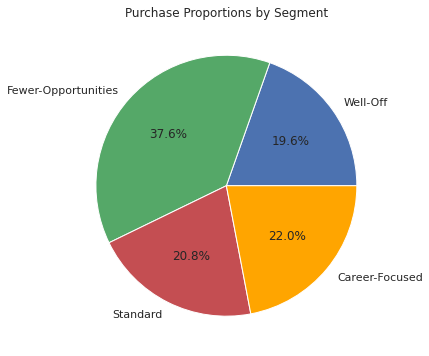

In [ ]:
plt.figure(figsize = (9, 6))
plt.pie(segm_prop['Purchase_Proportion_by_Segment'],
        labels = ['Well-Off', 'Fewer-Opportunities', 'Standard', 'Career-Focused'],
        autopct = '%1.1f%%',
        colors = ('b', 'g', 'r', 'orange'))
plt.title('Purchase Proportions by Segment')

####Average and Standard Deviation by Segment
In terms of store visits and purchases.

First, let's add 2 columns to calculate Average_Visits_by_Segment and Average_Purchases_by_Segment:

In [ ]:
# Add Average_N_Visits column
df_segments_means = df_purchase_descr[['Segment', 'N_Visits']].groupby(['Segment']).mean()
# Add Average_N_Purchases column
df_segments_means['Average_N_Purchases'] = df_purchase_descr[['Segment', 'N_Purchases']].groupby(['Segment']).mean()
# Rename column
df_segments_means = df_segments_means.rename(columns = {'N_Visits': 'Average_N_Visits'})
df_segments_means

,Average_N_Visits,Average_N_Purchases
Segment,,
0,117.295918,34.602041
1,113.835106,22.792553
2,117.471154,24.817308
3,123.454545,39.827273


Let's also add 2 columns to calculate Std_Visits_by_Segment and Std_Purchases_by_Segment:

In [ ]:
# Add Average_N_Visits column
df_segments_std = df_purchase_descr[['Segment', 'N_Visits']].groupby(['Segment']).std()
# Add Average_N_Purchases column
df_segments_std['Std_N_Purchases'] = df_purchase_descr[['Segment', 'N_Purchases']].groupby(['Segment']).std()
# Rename column
df_segments_std = df_segments_std.rename(columns = {'N_Visits': 'Std_N_Visits'})
df_segments_std

,Std_N_Visits,Std_N_Purchases
Segment,,
0,20.716152,25.900579
1,16.390601,13.843068
2,19.088937,16.715648
3,44.864656,53.744530


Now let's plot all of the averages and standard deviations to compare the differences in behavior between the 4 segments.

First, let's take a look at the bar chart plotting the 4 segments in terms of store visits (averages and standard deviations):

Text(0.5, 1.0, 'Average Number of Store Visits by Segment')

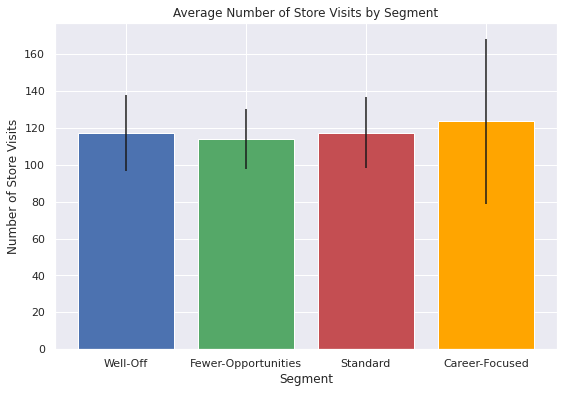

In [ ]:
plt.figure(figsize = (9, 6))
plt.bar(x = (0, 1, 2, 3),
        tick_label = ('Well-Off', 'Fewer-Opportunities', 'Standard', 'Career-Focused'),
        height = df_segments_means['Average_N_Visits'],
        yerr = df_segments_std['Std_N_Visits'],
        color = ('b', 'g', 'r', 'orange')
)
plt.xlabel('Segment')
plt.ylabel('Number of Store Visits')
plt.title('Average Number of Store Visits by Segment')

Observations:

1. Career-Focused segment has the highest average number of store visits (123), but also having the widest variability (standard deviation of 33). The large standard deviation implies customers within this group has very different store visit behavior, some visiting very often (over 165 times), while others much less frequently (80 times).
2. The other 3 segments have somewhat similar average number of store visits and not as wide variations.
3. Fewer-Opportunities segment has the lowest average number of store visits, with the lowest standard deviation (but as mentioned in point #2, the difference isn't much compared to Well-Off and Standard).

Likewise, let's take a look at the bar chart plotting the 4 segments in terms of purchases (averages and standard deviations):

Text(0.5, 1.0, 'Average Number of Purchases by Segment')

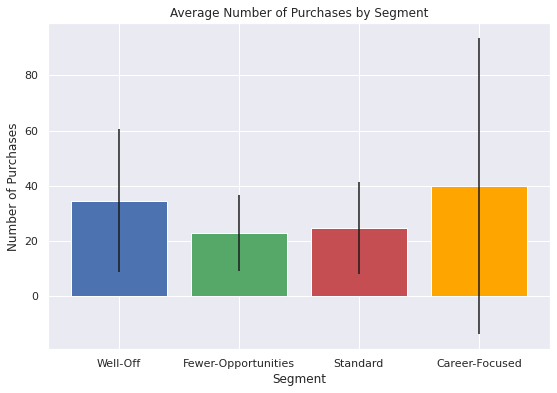

In [ ]:
plt.figure(figsize = (9, 6))
plt.bar(x = (0, 1, 2, 3),
        tick_label = ('Well-Off', 'Fewer-Opportunities', 'Standard', 'Career-Focused'),
        height = df_segments_means['Average_N_Purchases'],
        yerr = df_segments_std['Std_N_Purchases'],
        color = ('b', 'g', 'r', 'orange')
)
plt.xlabel('Segment')
plt.ylabel('Number of Purchases')
plt.title('Average Number of Purchases by Segment')

Observations:

1. Again, Career-Focused segment has the highest average number of purchases (39), but also with wildly large standard deviation (53).
2. Next is Well-Off segment in terms of average number of purchases, also with second largest standard deviation.
3. Next is Standard segment.
4. Fewer Opportunities has the lowest average number of purchases, and smallest standard deviation (but also not that different compared to the Standard segment).